In [20]:
import torch
import torch.nn as nn 

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"]=(16, 12)

In [2]:
#read appended bond data from github repo
bond_data = pd.read_csv("https://raw.githubusercontent.com/nurriol2/forecasting/master/datasets/old_school_bond_appended.csv", 
                        index_col="Unnamed: 0")
bond_data.head()

,Timestamps_close,Close,Timestamps_average,Average
0,2020/04/08,4134618,2020/04/08,4522980
1,2020/04/09,4009639,2020/04/09,4501601
2,2020/04/10,3903868,2020/04/10,4473252
3,2020/04/11,3853462,2020/04/11,4442300
4,2020/04/12,3941327,2020/04/12,4415261


In [3]:
bond_data.shape

(200, 4)

*Number of samples per set*  
170 - train    
20 - valid  
10 - test  

**So the task will be to predict bond price for the next 10 days given 170 training samples and 20 validation samples**

In [4]:
all_data = bond_data["Close"].values.astype(float)

In [5]:
training_data = all_data[:170]
validation_data = all_data[171:191]
test_data = all_data[-10:]

assert (len(training_data)+len(validation_data)+len(test_data))==all_data.shape[0]

In [6]:
#normalize the data sets
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
training_data_norm = scaler.fit_transform(training_data.reshape(-1, 1))

In [7]:
training_data_norm[:5], training_data_norm[-5:]

(array([[-0.21257071],
        [-0.34051259],
        [-0.4487911 ],
        [-0.50039208],
        [-0.41044406]]), array([[0.81887142],
        [0.81664793],
        [0.88317558],
        [0.93785894],
        [0.92705166]]))

In [8]:
training_data_norm = torch.FloatTensor(training_data_norm).view(-1)

In [9]:
#sequence length
train_window = 10

def create_inout_sequences(input_data, tw):
    #tw day sequence formed from interval slices of input_data
    inout_seq = []
    for i in range(len(input_data)-tw):
        #tw sequence
        train_seq = input_data[i:i+tw]
        #corresponding label (predicted price)
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))

    return inout_seq

train_inout_seq = create_inout_sequences(training_data_norm, train_window)

In [10]:
len(train_inout_seq)

160

In [11]:
class LSTM(nn.Module):

    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, dropout=0.2)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))
        return 

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [12]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [13]:
print(model)

LSTM(
  (lstm): LSTM(1, 100, dropout=0.2)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [14]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00529697
epoch:  26 loss: 0.00157086
epoch:  51 loss: 0.00049570
epoch:  76 loss: 0.00014182
epoch: 101 loss: 0.00000076
epoch: 126 loss: 0.00073781
epoch: 149 loss: 0.0021896614


In [15]:
fut_pred = 20

valid_inputs = training_data_norm[-train_window:].tolist()

In [16]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(valid_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        valid_inputs.append(model(seq).item())

valid_inputs[fut_pred:]

[0.7646702527999878,
 0.8301587700843811,
 0.914225697517395,
 0.9585343599319458,
 0.944609522819519,
 0.8722425699234009,
 0.7833842039108276,
 0.74263596534729,
 0.7866232991218567,
 0.8834882378578186]

In [17]:
actual_predictions = scaler.inverse_transform(np.array(valid_inputs[train_window:]).reshape(-1, 1))
print(actual_predictions)

[[5210532.91757727]
 [5147587.53636932]
 [5103525.23386002]
 [5121746.01091397]
 [5190971.52554584]
 [5251469.85501552]
 [5268532.14276624]
 [5234945.79288268]
 [5161327.54439735]
 [5095545.70719624]
 [5089228.01908565]
 [5153199.95328677]
 [5235320.05881429]
 [5278602.62122464]
 [5265000.25549006]
 [5194309.17648911]
 [5107508.59251666]
 [5067704.00166178]
 [5110672.67676079]
 [5205294.41724551]]


In [18]:
x = np.arange(171, 191, 1)
print(x)

[171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190]


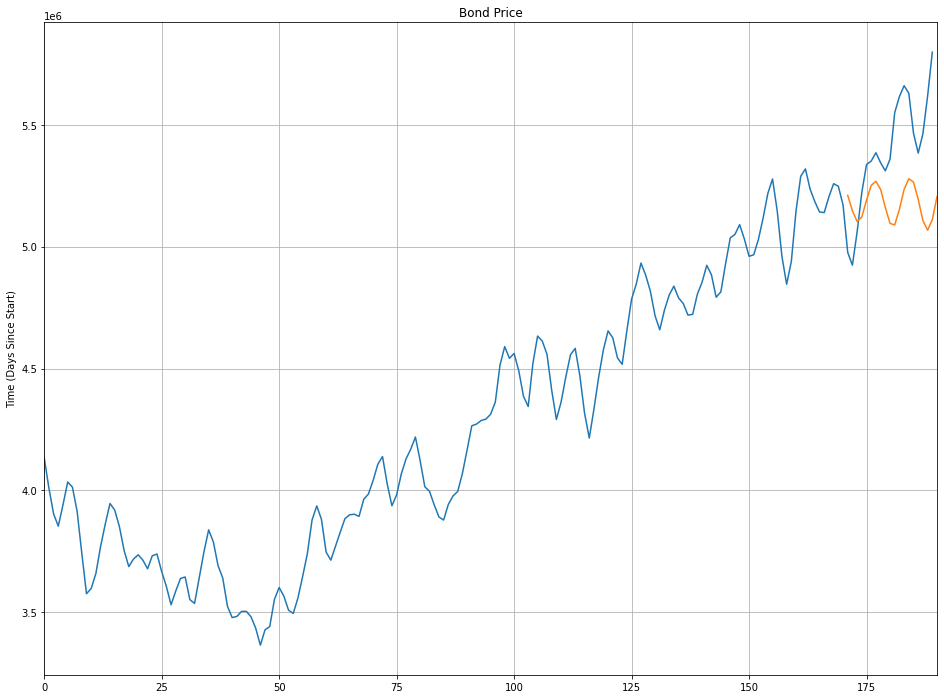

In [33]:
plt.title("Bond Price")
plt.ylabel("Time (Days Since Start)")
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(all_data[:-10])
plt.plot(x, actual_predictions)
plt.show()